# Test Analysis (Standalone)

Bu notebook, herhangi bir harici proje modülüne ihtiyaç duymadan LTE IQ verisini otomatik yükler ve temel analiz/grafikler üretir. Girdi öncelik sırası: `input.mat` (MATLAB RxWaveform) > `LTEIQ2.raw` > `LTEIQ.raw`. Meta veriden (varsa) LTE ayarlarını çıkarır, yoksa ham veri uzunluğundan 10 MHz / 20 MHz tahmini yapar. PSS eşleştirme ile hızlı senkron metriği ve temel zaman/frekans görselleri sağlar.

In [1]:

# Imports (standalone)
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
import h5py

try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass

plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True, precision=4)


In [2]:
# Helpers: loaders and config inference
from pathlib import Path

ROOT = Path.cwd().resolve()

class LTEConfig:
    def __init__(self, fs, nfft, ndlrb, cp_slot, symbols_per_slot=7, slots_per_subframe=2):
        self.fs = fs
        self.nfft = nfft
        self.ndlrb = ndlrb
        self.cp_slot = cp_slot
        self.symbols_per_slot = symbols_per_slot
        self.slots_per_subframe = slots_per_subframe
        self.subframe_samples = int(round(fs / 1000))
        self.slot_samples = int(round(fs / 2000))

def _decode_chars(arr):
    return ''.join(chr(int(c)) for c in np.array(arr).reshape(-1) if int(c) != 0)

def _cp_slot_from_meta(nfft: int, cp: str = 'Normal'):
    scale = nfft / 2048.0
    if str(cp).lower().startswith('norm'):
        first = int(round(160 * scale))
        rest = int(round(144 * scale))
        return (first,) + (rest,) * 6
    first = int(round(512 * scale))
    return (first,) + (first,) * 6

def _find_first(filenames):
    start = Path.cwd().resolve()
    for base in [start] + list(start.parents):
        for name in filenames:
            cand = base / name
            if cand.exists():
                return cand
    return None

def load_from_mat(path: Path):
    with h5py.File(path, 'r') as f:
        if 'RxWaveform' not in f:
            raise KeyError('RxWaveform dataset missing')
        arr = f['RxWaveform'][()]
        assert arr.dtype.names and {'real','imag'} <= set(arr.dtype.names), 'RxWaveform real/imag fields missing'
        x = (arr['real'] + 1j*arr['imag']).reshape(-1).astype(np.complex64)
        fs = float(f['TxInfo/SamplingRate'][0,0])
        nfft = int(f['TxInfo/Nfft'][0,0])
        ndlrb = int(f['Config/NDLRB'][0,0])
        cp_str = _decode_chars(f['TxInfo/CyclicPrefix'][()]) or 'Normal'
        ncellid = int(f['Config/NCellID'][0,0]) if 'Config/NCellID' in f else None
        nsubframe = int(f['Config/NSubframe'][0,0]) if 'Config/NSubframe' in f else None
        nframe = int(f['Config/NFrame'][0,0]) if 'Config/NFrame' in f else None
        cellrefp = int(f['Config/CellRefP'][0,0]) if 'Config/CellRefP' in f else None
        duplex_mode = _decode_chars(f['Config/DuplexMode'][()]) if 'Config/DuplexMode' in f else None
        phich_dur = _decode_chars(f['Config/PHICHDuration'][()]) if 'Config/PHICHDuration' in f else None
        ng_str = _decode_chars(f['Config/Ng'][()]) if 'Config/Ng' in f else None
    cfg = LTEConfig(fs=fs, nfft=nfft, ndlrb=ndlrb, cp_slot=_cp_slot_from_meta(nfft, cp_str))
    meta = {'source':'mat','fs':fs,'nfft':nfft,'ndlrb':ndlrb,'cp':cp_str, 'path': str(path),
            'NCellID': ncellid, 'NSubframe': nsubframe, 'NFrame': nframe, 'CellRefP': cellrefp,
            'DuplexMode': duplex_mode, 'PHICHDuration': phich_dur, 'Ng': ng_str}
    return x, cfg, meta

def load_from_raw(path: Path):
    raw = np.fromfile(path, dtype=np.float32)
    if raw.size % 2:
        raw = raw[:-1]
    x = raw[0::2] + 1j*raw[1::2]
    n = x.size
    fs_guess = 30.72e6 if n > 250_000 else 15.36e6
    nfft = 2048 if fs_guess > 20e6 else 1024
    ndlrb = 100 if fs_guess > 20e6 else 50
    cfg = LTEConfig(fs=fs_guess, nfft=nfft, ndlrb=ndlrb, cp_slot=_cp_slot_from_meta(nfft, 'Normal'))
    meta = {'source':'raw','fs':fs_guess,'nfft':nfft,'ndlrb':ndlrb,'cp':'Normal', 'path': str(path)}
    return x.astype(np.complex64), cfg, meta

def auto_load():
    mat_path = _find_first(['input.mat'])
    raw_path = _find_first(['LTEIQ2.raw', 'LTEIQ.raw'])
    if mat_path:
        print(f'Using MATLAB capture: {mat_path}')
        return load_from_mat(mat_path)
    if raw_path:
        print(f'Using RAW capture: {raw_path}')
        return load_from_raw(raw_path)
    raise FileNotFoundError('No input.mat or LTEIQ*.raw found (searched cwd and parents).')

x, config, meta = auto_load()
print('Meta:', meta)
print('Samples:', len(x))


Using MATLAB capture: /home/fse/Desktop/Fall25/HHS/yHHS/input.mat
Meta: {'source': 'mat', 'fs': 30720000.0, 'nfft': 2048, 'ndlrb': 100, 'cp': 'Normal', 'path': '/home/fse/Desktop/Fall25/HHS/yHHS/input.mat', 'NCellID': 42, 'NSubframe': 0, 'NFrame': 0, 'CellRefP': 1, 'DuplexMode': 'FDD', 'PHICHDuration': 'Normal', 'Ng': 'Sixth'}
Samples: 307200


In [3]:

# PSS generation and matched filter (3GPP 36.211)

def _zc_root_for_nid2(nid2):
    return {0:25, 1:29, 2:34}[int(nid2)]

def generate_pss_fd(nfft, nid2):
    u = _zc_root_for_nid2(nid2)
    Nzc = 63
    n = np.arange(Nzc)
    x_zc = np.exp(-1j * np.pi * u * n * (n + 1) / Nzc)
    X = np.zeros(nfft, dtype=np.complex64)
    dc = nfft // 2
    X[dc-31:dc] = x_zc[0:31]
    X[dc+1:dc+32] = x_zc[32:63]
    return X

def generate_pss_td(nfft, nid2):
    return np.fft.ifft(np.fft.ifftshift(generate_pss_fd(nfft, nid2)))

def coarse_cfo_estimate(symbol_td, cp_len, nfft):
    cp = symbol_td[:cp_len]
    data = symbol_td[cp_len:cp_len+nfft]
    if len(cp)==0:
        return 0.0
    r = np.vdot(cp, data[:cp_len])
    angle = np.angle(r)
    return float(angle / nfft)

def detect_pss(x, cfg):
    cp_pss = int(cfg.cp_slot[6])
    best = {'nid2': None, 'metric': -1.0, 'sample_index': None, 'cfo': 0.0}
    sig_energy = np.abs(x)**2
    for nid2 in (0,1,2):
        td = generate_pss_td(cfg.nfft, nid2)
        ref = np.concatenate([td[-cp_pss:], td])
        ref_energy = float(np.sum(np.abs(ref)**2) + 1e-12)
        mf = np.conjugate(ref[::-1])
        corr = signal.fftconvolve(x, mf, mode='valid')
        power = np.abs(corr)**2
        idx = int(np.argmax(power))
        win_energy = float(np.sum(sig_energy[idx:idx+ref.size]) + 1e-12)
        metric = float(power[idx] / (ref_energy * win_energy + 1e-12))
        if metric > best['metric']:
            best.update({'nid2': nid2, 'metric': metric, 'sample_index': idx})
    if best['sample_index'] is not None:
        seg = x[best['sample_index']:best['sample_index']+cp_pss+cfg.nfft]
        if seg.size >= cp_pss + cfg.nfft:
            best['cfo'] = coarse_cfo_estimate(seg, cp_pss, cfg.nfft)
    return best

pss_res = detect_pss(x, config)
print('PSS result:', pss_res)


PSS result: {'nid2': 0, 'metric': 0.6886139512062073, 'sample_index': 166768, 'cfo': 0.00042809481965377927}


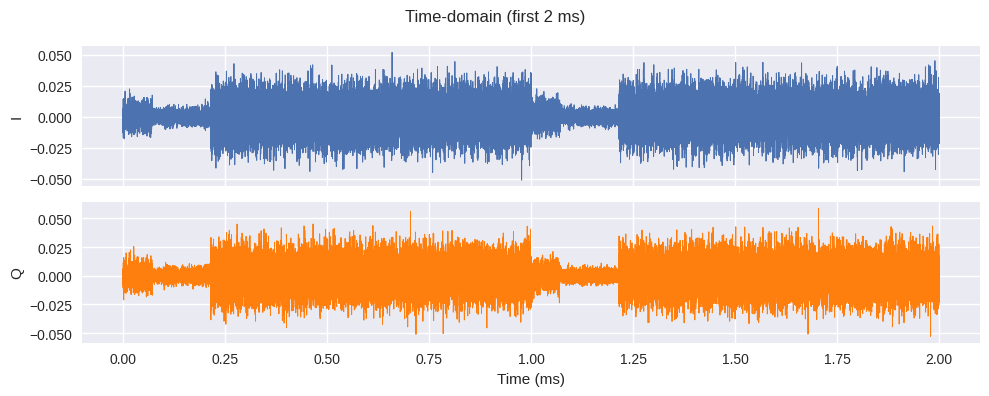

In [4]:

# Time-domain preview
ms = np.arange(len(x)) / config.fs * 1e3
sel = slice(0, int(config.fs*0.002))
fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(ms[sel], np.real(x[sel]), lw=0.7)
ax[0].set_ylabel('I')
ax[1].plot(ms[sel], np.imag(x[sel]), lw=0.7, color='tab:orange')
ax[1].set_ylabel('Q')
ax[1].set_xlabel('Time (ms)')
fig.suptitle('Time-domain (first 2 ms)')
fig.tight_layout()
plt.show()


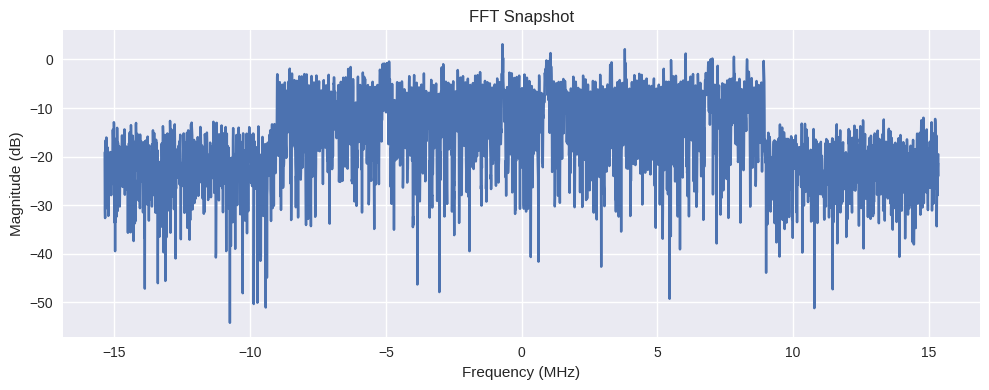

In [5]:

# Spectrum snapshot
N = 4096 if config.nfft >= 2048 else 2048
window = signal.windows.hann(N)
X = np.fft.fftshift(np.fft.fft(x[:N] * window, N))
freq_mhz = (np.arange(N) - N//2) / N * config.fs / 1e6
plt.figure(figsize=(10,4))
plt.plot(freq_mhz, 20*np.log10(np.abs(X)+1e-12))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnitude (dB)')
plt.title('FFT Snapshot')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:

# Report summary
print('Meta:', meta)
print('PSS:', pss_res)
print('Derived config: fs={config.fs/1e6:.2f} MHz, nfft={config.nfft}, ndlrb={config.ndlrb}, CP_slot0={config.cp_slot}')


Meta: {'source': 'mat', 'fs': 30720000.0, 'nfft': 2048, 'ndlrb': 100, 'cp': 'Normal', 'path': '/home/fse/Desktop/Fall25/HHS/yHHS/input.mat', 'NCellID': 42, 'NSubframe': 0, 'NFrame': 0, 'CellRefP': 1, 'DuplexMode': 'FDD', 'PHICHDuration': 'Normal', 'Ng': 'Sixth'}
PSS: {'nid2': 0, 'metric': 0.6886139512062073, 'sample_index': 166768, 'cfo': 0.00042809481965377927}
Derived config: fs={config.fs/1e6:.2f} MHz, nfft={config.nfft}, ndlrb={config.ndlrb}, CP_slot0={config.cp_slot}


## Ek Çıktılar

Aşağıdaki hücreler PSS korelasyon izi, spektrogram, sembol/alt-kare enerji ısı haritası ve kaba bir konstelasyon önizlemesini üretir.

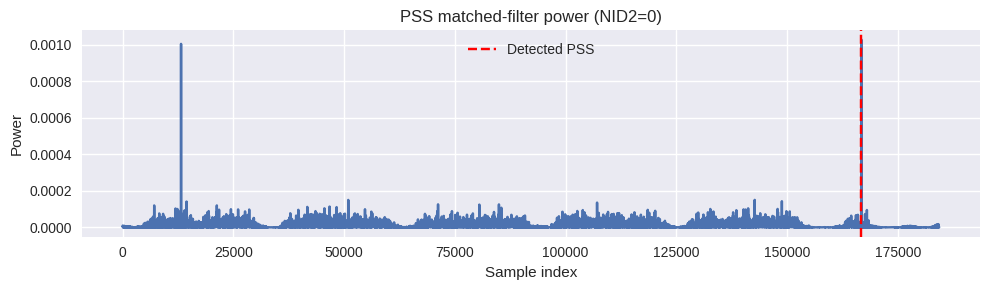

In [7]:

# PSS matched-filter power (viz)
if 'pss_res' in globals() and pss_res.get('sample_index') is not None:
    best_nid2 = int(pss_res['nid2'])
    cp_pss = int(config.cp_slot[6])
    td = generate_pss_td(config.nfft, best_nid2)
    ref = np.concatenate([td[-cp_pss:], td])
    mf = np.conjugate(ref[::-1])
    corr = signal.fftconvolve(x, mf, mode='valid')
    power = np.abs(corr)**2
    span = min(len(power), config.subframe_samples * 6)
    plt.figure(figsize=(10,3))
    plt.plot(power[:span])
    plt.axvline(pss_res['sample_index'], color='r', ls='--', label='Detected PSS')
    plt.title(f'PSS matched-filter power (NID2={best_nid2})')
    plt.xlabel('Sample index')
    plt.ylabel('Power')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('PSS not detected; skipping correlation plot.')


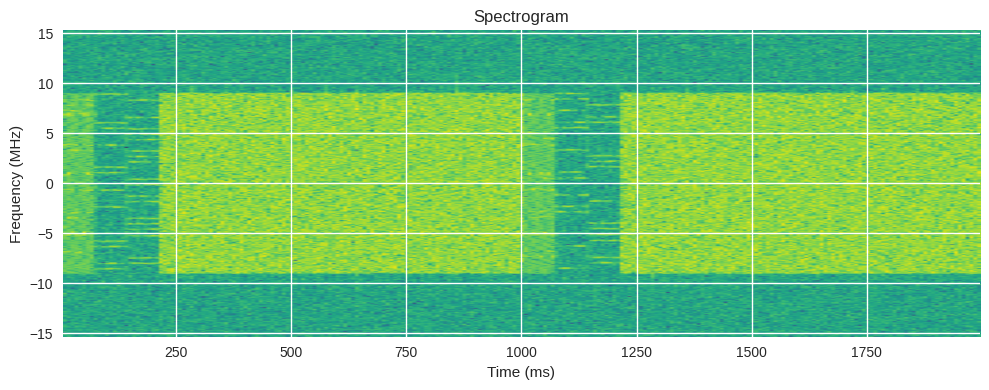

In [8]:

# Spectrogram (first ~2 subframes)
seg = x[:int(config.subframe_samples*2)]
plt.figure(figsize=(10,4))
plt.specgram(seg, NFFT=512, Fs=config.fs/1e6, noverlap=256, scale='dB', cmap='viridis')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


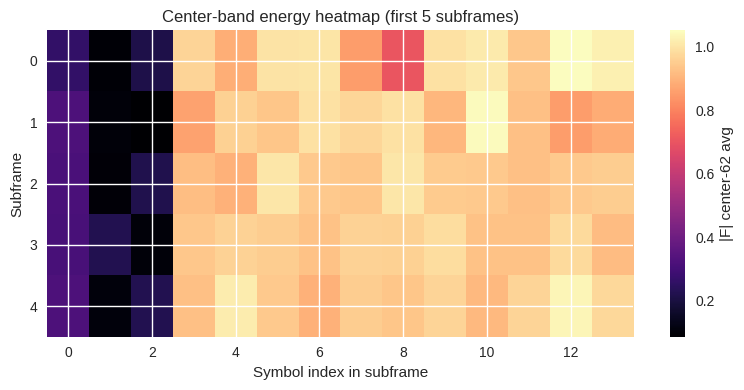

In [9]:

# Center-band energy heatmap per symbol (first 5 subframes)

def _symbol_starts(cfg, subframes=5):
    sym_len = [int(cfg.cp_slot[i] + cfg.nfft) for i in range(cfg.symbols_per_slot)]
    starts = []
    for sf in range(subframes):
        base = sf * cfg.subframe_samples
        s = base
        for l in range(cfg.symbols_per_slot * cfg.slots_per_subframe):
            starts.append(s)
            cp_idx = l % cfg.symbols_per_slot
            s += sym_len[cp_idx]
    return starts

def _center_mask(nfft, n_sc=62):
    dc = nfft // 2
    mask = np.zeros(nfft, dtype=bool)
    half = n_sc // 2
    mask[dc-half:dc] = True
    mask[dc+1:dc+1+half] = True
    return mask

subframes = 5
starts = _symbol_starts(config, subframes=subframes)
mask = _center_mask(config.nfft, 62)
energy = []
for s in starts:
    seg = x[s:s+config.nfft]
    if len(seg) < config.nfft:
        energy.append(0.0)
        continue
    F = np.fft.fftshift(np.fft.fft(seg, config.nfft))
    energy.append(float(np.mean(np.abs(F[mask]))))
energy = np.array(energy).reshape(subframes, config.symbols_per_slot * config.slots_per_subframe)
plt.figure(figsize=(8,4))
plt.imshow(energy, aspect='auto', cmap='magma')
plt.colorbar(label='|F| center-62 avg')
plt.xlabel('Symbol index in subframe')
plt.ylabel('Subframe')
plt.title('Center-band energy heatmap (first 5 subframes)')
plt.tight_layout()
plt.show()


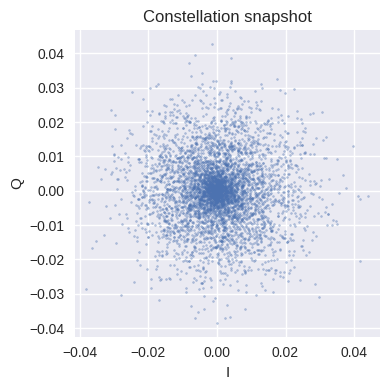

In [10]:

# Constellation snapshot (random subset)
np.random.seed(0)
sel_idx = np.random.choice(len(x), size=min(5000, len(x)), replace=False)
plt.figure(figsize=(4,4))
plt.scatter(np.real(x[sel_idx]), np.imag(x[sel_idx]), s=2, alpha=0.4)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('Constellation snapshot')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [11]:

# Broadcast fields summary (meta + detections)
fields = {
    'NDLRB': meta.get('ndlrb'),
    'DuplexMode': meta.get('DuplexMode') or 'FDD',
    'CyclicPrefix': meta.get('cp'),
    'NCellID': meta.get('NCellID'),
    'NSubframe': meta.get('NSubframe'),
    'CellRefP': meta.get('CellRefP'),
    'PHICHDuration': meta.get('PHICHDuration'),
    'Ng': meta.get('Ng'),
    'NFrame': meta.get('NFrame'),
}
# Derive NID1/NID2 if possible
if fields['NCellID'] is not None:
    fields['NID1'] = int(fields['NCellID']) // 3
    fields['NID2'] = int(fields['NCellID']) % 3
elif 'pss_res' in globals() and pss_res.get('nid2') is not None:
    fields['NID2'] = int(pss_res['nid2'])
else:
    fields['NID2'] = None
print('Fields (meta-derived where available):')
for k,v in fields.items():
    print(f"{k}: {v}")


Fields (meta-derived where available):
NDLRB: 100
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 42
NSubframe: 0
CellRefP: 1
PHICHDuration: Normal
Ng: Sixth
NFrame: 0
NID1: 14
NID2: 0
